In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

import sys
sys.path.insert(0, "C:\\Users\zachc\Documents\GitHub")
import SMT.core.transport as SMT
from SMT.core.physical_constants import *
from SMT.core.physical_parameters import rs_from_n, Degeneracy_Parameter

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

/tmp/ipykernel_572789/2370064656.py:5: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))
/tmp/ipykernel_572789/2370064656.py:12: RuntimeWarning: overflow encountered in exp
  f_fd = lambda eps: 1/(1 + np.exp(eps-eta))


(1.0959596793105735, 1000.0)

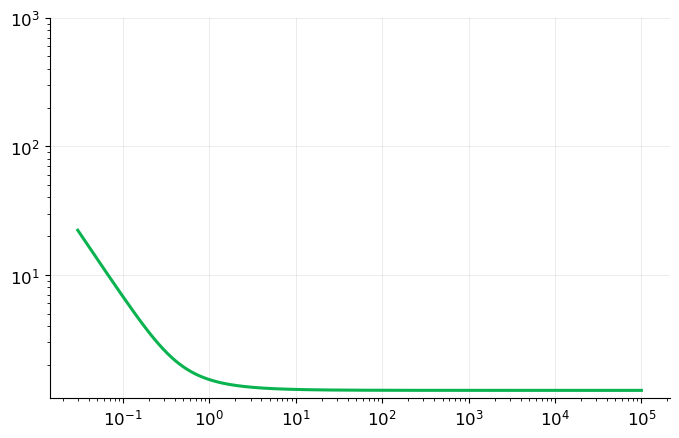

In [2]:
# First try
from scipy.integrate import quad
@np.vectorize
def sigma_integral(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

@np.vectorize
def sigma_integral_PB(eta):    
    f_fd = lambda eps: 1/(1 + np.exp(eps-eta))  
    integral = lambda eps: (1-f_fd(eps))*f_fd(eps)*np.sqrt(eps)
    int_of_theta = quad(integral, 0, 1e4 )
    return int_of_theta[0]

fig, ax  = plt.subplots()

theta_array = np.geomspace(3e-2,1e5, num=1000)
sigma_f = sigma_integral(1/theta_array)
sigma_f_PB = sigma_integral_PB(1/theta_array)


# a=1
# b=1.5
# c=0.99
# n=2
f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**n)**(1/n)
# popt, pcov = curve_fit(f_approx,theta_array, sigma_f/sigma_f_PB, p0=[1, 1,1] ) 
# print(popt)
# ax.plot(theta_array, f_approx(theta_array, *popt))
# ax.plot(theta_array, f_approx(theta_array, 1,1))
ax.plot(theta_array, sigma_f/sigma_f_PB)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(None,1e3)


##
$$K_{nm}(g) = g^m \int^\infty_0 d\omega  e^{-g \omega^2} \omega^{2m+3} \phi_n(\omega)$$
Now let $-g \omega^2 = -\beta \epsilon$, so $\epsilon $
This means Boltzmann factor 
$$f_B = e^{-g \omega^2} = e^{-\beta \epsilon},$$
can be turned into the F-D distribution, as
$$f_{F-D} = 1/( 1 + e^{g \omega^2 - \eta} )$$
for $\eta \equiv \beta E_F $

Assuming now that $\phi_n(g)\sim A_n$, for some constant A. Then with $\epsilon=g \omega^2$
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon  e^{-\epsilon} \epsilon^{m+1} $$
which becomes 
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon f_{FD}(\epsilon, \eta) \epsilon^{m+1} $$
for Fermi-Dirac, 
$$
 f_{FD = \frac{1}{1 + e^{\epsilon - \eta}}
$$
and 
$$K_{nm}(g) = \frac{A_n}{2 g^{2}} \int^\infty_0 d\epsilon (1-f_{FD}) f_{FD}   \epsilon^{m+1} $$
for the Pauli blocked version


# First electron-ion

a_ei_11,b_ei_11,n_ei_11 = 3.009e-01,1.102e+00,1.788e+00 # K_1,1
a_ei_12,b_ei_12,n_ei_12 = 2.361e-01,1.054e+00,1.864e+00 # K_1,2
a_ei_22,b_ei_22,n_ei_22 = 2.361e-01,1.054e+00,1.864e+00 # K_2,2
a_ei_13,b_ei_13,n_ei_13 = 1.940e-01,1.029e+00,1.969e+00 # K_1,3


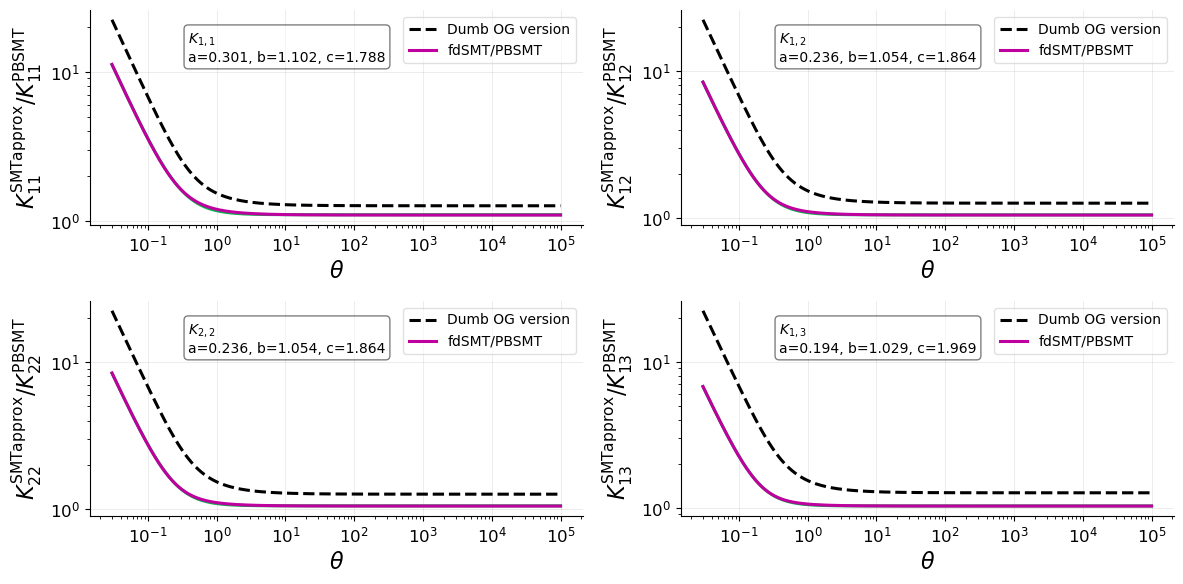

In [3]:
from scipy.optimize import curve_fit

f_fd = lambda ε, η: 1/(1 + np.exp(ε - η)) 
f_b  = lambda ε, η: np.exp(-ε + η) 

# f_fd = lambda ε, η: 1/(1 + np.exp(ε - η)) * np.exp(-η) #Move η??
# f_b  = lambda ε, η: np.exp(-ε) #Move η??

def K_nm_bSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_b(ε,η)*ε**(m+1)

def K_nm_fdSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε,η)*ε**(m+1)#* 2/(1 + 10*ε**2)

def K_nm_PBSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε, η)*(1-f_fd(ε, η))*ε**(m+1) #* 2/(1 + 10*ε**2)

def plot_Knm(n,m, ax = None):
    if ax is None:
        fig, ax  = plt.subplots()

    theta_array = np.geomspace(3e-2,1e5, num=1000)
    # Original roughly
    max_ε = 1e2
    bSMT_integral =  lambda η: quad(K_nm_bSMT_integrand(n,m,η),0,max_ε )[0]
    bSMT_integral = np.vectorize(bSMT_integral)
    bSMT_vals = bSMT_integral(1 + 0*theta_array)
    
    fdSMT_integral =  lambda η: quad(K_nm_fdSMT_integrand(n,m,η),0,max_ε )[0]
    fdSMT_integral = np.vectorize(fdSMT_integral)
    fdSMT_vals = fdSMT_integral(1/theta_array)
    
    
#     # New
    PBSMT_integral = lambda η: quad(K_nm_PBSMT_integrand(n,m,η),0,max_ε )[0]
    PBSMT_integral = np.vectorize(PBSMT_integral)
    PBSMT_vals = PBSMT_integral(1/theta_array) 
    
    
    f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**n)**(1/n)
    popt, pcov = curve_fit(f_approx,theta_array, fdSMT_vals/PBSMT_vals, p0=[1, 1,1] ) 
    fit_a, fit_b, fit_n = popt
    print(f"a_ei_{n}{m},b_ei_{n}{m},n_ei_{n}{m} = {fit_a:0.3e},{fit_b:0.3e},{fit_n:0.3e} # K_{n},{m}")
    ax.plot(theta_array, f_approx(theta_array, *popt))
    # ax.plot(theta_array, f_approx(theta_array, 1,1))
    
    ax.plot(theta_array, sigma_f/sigma_f_PB, 'k--',label='Dumb OG version',alpha=1)
    # # ax.plot(theta_array, bSMT_vals/PBSMT_vals, label='bSMT/PBSMT')
    ax.plot(theta_array, fdSMT_vals/PBSMT_vals, label='fdSMT/PBSMT')
    # ax.plot(theta_array, bSMT_vals/fdSMT_vals, label='bSMT/fdSMT')
    # ax.set_ylim(None,1e3)
    
    # ax.plot(theta_array, bSMT_vals, label='bSMT')
    # ax.plot(theta_array, fdSMT_vals, label='fdSMT')
    # ax.plot(theta_array, PBSMT_vals, label='PBSMT')
    # ax.set_ylim(1e-2,2e1)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r"$K^{{\rm SMT approx}}_{{ {0} {1} }}/K^{{\rm PB SMT}}_{{ {0} {1} }}$".format(n,m))
    ax.set_xlabel(r"$\theta$")
    ax.legend()
    return popt

fig, axs = plt.subplots(2,2, figsize=(12,6))
axs = axs.flatten()

fit_11 = plot_Knm(1,1, ax=axs[0])
fit_12 = plot_Knm(1,2, ax=axs[1])
fit_22 = plot_Knm(2,2, ax=axs[2])
fit_13 = plot_Knm(1,3, ax=axs[3])

labels = [r"$K_{1,1}$",r"$K_{1,2}$",r"$K_{2,2}$",r"$K_{1,3}$"]
fits = [fit_11,fit_12,fit_22,fit_13]

for text, fit, ax in zip(labels,fits,axs):
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.2, 0.9, text + '\n' + "a={0:0.3f}, b={1:0.3f}, c={2:0.3f}".format(*fit) , transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=bbox)
    

plt.tight_layout()


# Now electron-electron

a_ee_11,b_ee_11,n_ee_11,m_ee_11 = 7.702e-01,1.500e+00,2.254e+00,1.146e+00 # K_1,1
a_ee_12,b_ee_12,n_ee_12,m_ee_12 = 6.066e-01,1.331e+00,2.076e+00,1.172e+00 # K_1,2
a_ee_22,b_ee_22,n_ee_22,m_ee_22 = 6.066e-01,1.331e+00,2.076e+00,1.172e+00 # K_2,2


/tmp/ipykernel_572789/3602056874.py:53: RuntimeWarning: invalid value encountered in power
  f_approx = lambda theta, a, b, n, m: b*(1 + (a/theta)**(m*n))**(1/n)


a_ee_13,b_ee_13,n_ee_13,m_ee_13 = 4.975e-01,1.225e+00,1.987e+00,1.196e+00 # K_1,3


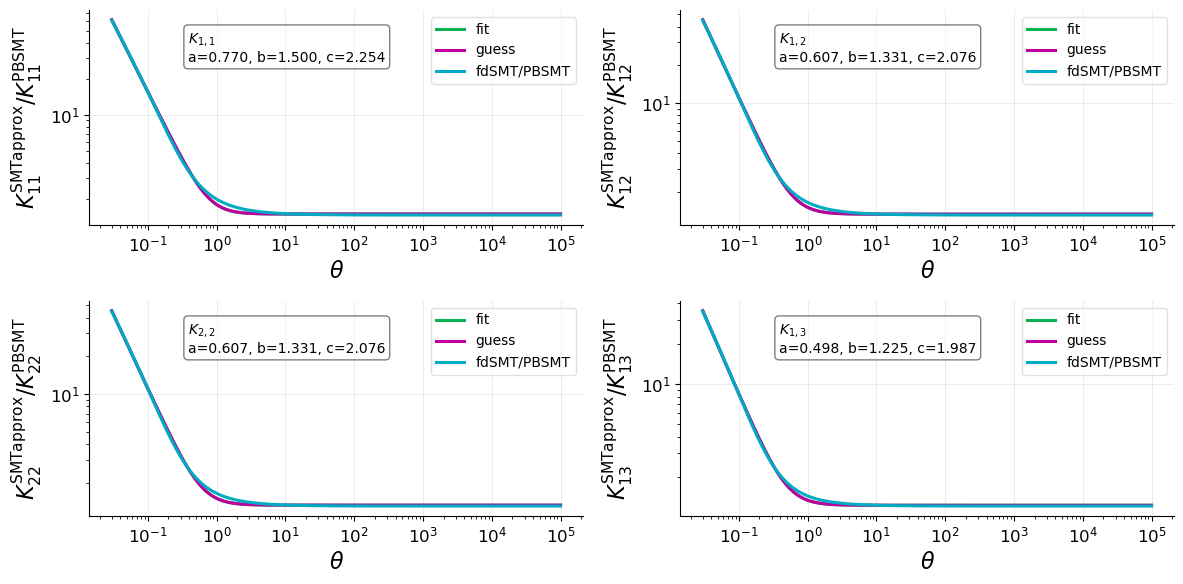

In [23]:
from scipy.optimize import curve_fit

f_fd = lambda ε, η: 1/(1 + np.exp(ε - η)) 
f_b  = lambda ε, η: np.exp(-ε + η) 

# f_fd = lambda ε, η: 1/(1 + np.exp(ε - η)) * np.exp(-η) #Move η??
# f_b  = lambda ε, η: np.exp(-ε) #Move η??

def K_nm_bSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_b(ε,η)*ε**(m+1)

def K_nm_fdSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε,η)*f_fd(ε,η)*ε**(m+1)#* 2/(1 + 10*ε**2)

def K_nm_PBSMT_integrand(n,m,η): # ω^2 = ε = β 
    if n==1:
        An = 15.944
    elif n==2:
        An = 7.8182
    return lambda ε: An/2 * f_fd(ε, η)*(1-f_fd(ε, η))*f_fd(ε, η)*(1-f_fd(ε, η))*ε**(m+1) #* 2/(1 + 10*ε**2)

def plot_Knm(n,m, ax = None):
    if ax is None:
        fig, ax  = plt.subplots()

    theta_array = np.geomspace(3e-2,1e5, num=1000)
    # Original roughly
    max_ε = 1e2
    bSMT_integral =  lambda η: quad(K_nm_bSMT_integrand(n,m,η),0,max_ε )[0]
    bSMT_integral = np.vectorize(bSMT_integral)
    bSMT_vals = bSMT_integral(1 + 0*theta_array)
    
    fdSMT_integral =  lambda η: quad(K_nm_fdSMT_integrand(n,m,η),0,max_ε )[0]
    fdSMT_integral = np.vectorize(fdSMT_integral)
    fdSMT_vals = fdSMT_integral(1/theta_array)
    
    
#     # New
    PBSMT_integral = lambda η: quad(K_nm_PBSMT_integrand(n,m,η),0,max_ε )[0]
    PBSMT_integral = np.vectorize(PBSMT_integral)
    PBSMT_vals = PBSMT_integral(1/theta_array) 
    
    
    # f_approx = lambda theta, a, b, n: b*(1 + (a/theta)**(n))**(1/n)
    f_approx = lambda theta, a, b, n, m: b*(1 + (a/theta)**(m*n))**(1/n)
    # f_approx = lambda theta, a, b, n: b*(1 + a*theta**(-1) + n*theta**(-2))#**(1/n)
    popt=[1,1,1,1]
    popt, pcov = curve_fit(f_approx,theta_array, fdSMT_vals/PBSMT_vals, p0=popt ) 
    fit_a, fit_b, fit_n, fit_m = popt
    # fit_a, fit_b, fit_n = popt
    # print(f"a_ei_{n}{m},b_ei_{n}{m},n_ei_{n}{m} = {fit_a:0.3e},{fit_b:0.3e},{fit_n:0.3e} # K_{n},{m}")
    print(f"a_ee_{n}{m},b_ee_{n}{m},n_ee_{n}{m},m_ee_{n}{m} = {fit_a:0.3e},{fit_b:0.3e},{fit_n:0.3e},{fit_m:0.3e} # K_{n},{m}")
    ax.plot(theta_array, f_approx(theta_array, *popt),label='fit')
    ax.plot(theta_array, f_approx(theta_array, *popt),label='guess')
    
    # ax.plot(theta_array, sigma_f/sigma_f_PB, 'k--',label='Dumb OG version',alpha=1)
    # # ax.plot(theta_array, bSMT_vals/PBSMT_vals, label='bSMT/PBSMT')
    ax.plot(theta_array, fdSMT_vals/PBSMT_vals, label='fdSMT/PBSMT')
    # ax.plot(theta_array, bSMT_vals/fdSMT_vals, label='bSMT/fdSMT')
    # ax.set_ylim(None,1e3)
    
    # ax.plot(theta_array, bSMT_vals, label='bSMT')
    # ax.plot(theta_array, fdSMT_vals, label='fdSMT')
    # ax.plot(theta_array, PBSMT_vals, label='PBSMT')
    # ax.set_ylim(1e-2,2e1)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r"$K^{{\rm SMT approx}}_{{ {0} {1} }}/K^{{\rm PB SMT}}_{{ {0} {1} }}$".format(n,m))
    ax.set_xlabel(r"$\theta$")
    ax.legend()
    return popt

fig, axs = plt.subplots(2,2, figsize=(12,6))
axs = axs.flatten()

fit_11 = plot_Knm(1,1, ax=axs[0])
fit_12 = plot_Knm(1,2, ax=axs[1])
fit_22 = plot_Knm(2,2, ax=axs[2])
fit_13 = plot_Knm(1,3, ax=axs[3])

labels = [r"$K_{1,1}$",r"$K_{1,2}$",r"$K_{2,2}$",r"$K_{1,3}$"]
fits = [fit_11,fit_12,fit_22,fit_13]

for text, fit, ax in zip(labels,fits,axs):
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.2, 0.9, text + '\n' + "a={0:0.3f}, b={1:0.3f}, c={2:0.3f}".format(*fit) , transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=bbox)
    

plt.tight_layout()
